In [44]:
import os
import glob
import pandas as pd
import numpy as np
import cv2
import locale
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Activation, 
    Flatten, Dropout, Dense, 
    Input, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

In [23]:
dataset_path = "/home/smbh/Projects/house-price-prediction/data/raw/houses-dataset/houses_dataset"

In [24]:
cols = [
    "bedrooms",
    "bathrooms",
    "area",
    "zipcode",
    "price"
]
df = pd.read_csv(dataset_path + "/HousesInfo.txt", sep=" ", header=None, names=cols)
df.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [25]:
# zipcode to categorical
df["zipcode"] = df["zipcode"].astype("str")

In [26]:
zipcodes, count = np.unique(
    df["zipcode"],
    return_counts=True
)
# dict(zip(zipcodes, count))
df.shape

(535, 5)

In [27]:
# plot histogram of zip codes
fig = px.histogram(
    df,
    x="zipcode",
    nbins=70,
    title="Histogram of Zip Codes"
)
fig.show()

In [28]:
# delete zip codes with less than 25 houses
for (zipcode, count) in zip(zipcodes, count):
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)
df.shape

(362, 5)

In [29]:
# plot histogram of zip codes
fig = px.histogram(
    df,
    x="zipcode",
    nbins=70,
    title="Histogram of Zip Codes"
)
fig.show()

In [30]:
images = []

for i in df.index.values:
    base_path = os.path.sep.join([dataset_path, "{}_*".format(i + 1)])
    house_paths = sorted(list(glob.glob(base_path)))
    input_images = []
    output_images = np.zeros((64, 64, 3), dtype="uint8")
    for house_path in house_paths:
        image = cv2.imread(house_path)
        image = cv2.resize(image, (32, 32))
        input_images.append(image)
    output_images[0:32, 0:32] = input_images[0]
    output_images[0:32, 32:64] = input_images[1]
    output_images[32:64, 32:64] = input_images[2]
    output_images[32:64, 0:32] = input_images[3]
    images.append(output_images)
images = np.array(images)
images.shape

(362, 64, 64, 3)

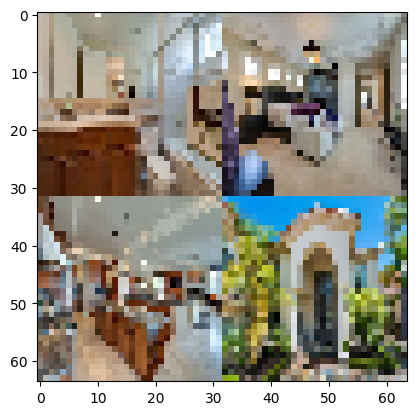

In [31]:
plt.imshow(images[37][..., ::-1])

In [32]:
images = images / 255.0

In [33]:
x_train_attr, x_test_attr, x_train_images, x_test_images = train_test_split(
    df,
    images,
    test_size=0.25,
    random_state=42
)
x_train_attr.shape, x_test_attr.shape, x_train_images.shape, x_test_images.shape

((271, 5), (91, 5), (271, 64, 64, 3), (91, 64, 64, 3))

In [34]:
# Normalization
max_price = df["price"].max()
y_train = x_train_attr["price"] / max_price
y_test = x_test_attr["price"] / max_price
# drop price from x_train_attr and x_test_attr
x_train_attr.drop("price", axis=1, inplace=True)
x_test_attr.drop("price", axis=1, inplace=True)

In [37]:
width, height, depth = x_train_images.shape[1:]
width, height, depth

(64, 64, 3)

In [39]:
filters = (16, 32, 64)
input_shape = (width, height, depth)
channel_dim = -1

In [46]:
inputs = Input(shape=input_shape)

for (i, f) in enumerate(filters):
    if i == 0:
        x = inputs
    # CONV => RELU => BN => POOL
    x = Conv2D(f, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=channel_dim)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

# flatten the volume, then FC => RELU => BN => DROPOUT
x = Flatten()(x)
x = Dense(16)(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# apply another FC layer, this one to match the number of nodes
# coming out of the MLP
x = Dense(4)(x)
x = Activation("relu")(x)

x = Dense(1, activation="linear")(x)

model = Model(inputs, x)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 activation_5 (Activation)   (None, 64, 64, 16)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640

In [47]:
opt = Adam(learning_rate=1e-3, weight_decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [48]:
history = model.fit(
    x_train_images,
    y_train,
    validation_data=(x_test_images, y_test),
    epochs=200,
    batch_size=16
)

Epoch 1/200
17/17 [==============================] - 1s 19ms/step - loss: 1301.3887 - val_loss: 362.5304
Epoch 2/200
17/17 [==============================] - 0s 12ms/step - loss: 1041.0563 - val_loss: 107.8356
Epoch 3/200
17/17 [==============================] - 0s 11ms/step - loss: 860.6103 - val_loss: 96.6201
Epoch 4/200
17/17 [==============================] - 0s 12ms/step - loss: 615.0280 - val_loss: 118.8261
Epoch 5/200
17/17 [==============================] - 0s 11ms/step - loss: 652.7861 - val_loss: 277.7156
Epoch 6/200
17/17 [==============================] - 0s 11ms/step - loss: 471.3102 - val_loss: 269.9859
Epoch 7/200
17/17 [==============================] - 0s 11ms/step - loss: 529.7211 - val_loss: 168.0555
Epoch 8/200
17/17 [==============================] - 0s 11ms/step - loss: 464.1613 - val_loss: 143.4172
Epoch 9/200
17/17 [==============================] - 0s 11ms/step - loss: 477.4701 - val_loss: 332.8501
Epoch 10/200
17/17 [==============================] - 0s 11ms/s

In [49]:
# Plot training and validation loss
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=history.history["loss"],
    name="Training Loss"
))
fig.add_trace(go.Scatter(
    y=history.history["val_loss"],
    name="Validation Loss"
))
fig.update_layout(
    title="Training and Validation Loss",
    xaxis_title="Epoch",
    yaxis_title="Loss"
)
fig.show()

In [50]:
preds = model.predict(x_test_images)

3/3 [==============================] - 0s 7ms/step


In [51]:
diff = preds.flatten() - y_test
percent_diff = (diff / y_test) * 100
abs_percent_diff = np.abs(percent_diff)

mean = np.mean(abs_percent_diff)
std = np.std(abs_percent_diff)

In [52]:
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print(f"avg. house price: {locale.currency(df['price'].mean(), grouping=True)}")
print(f"mean: {mean:.2f}%, std: {std:.2f}%")

avg. house price: $533,388.27
mean: 50.23%, std: 85.25%
